In [ ]:

!pip install tensorflow==1.15
!pip install keras==2.3.1


     |████████████████████████████████| 412.3MB 38kB/s 
     |████████████████████████████████| 3.8MB 34.2MB/s 
     |████████████████████████████████| 51kB 6.9MB/s 
     |████████████████████████████████| 512kB 40.0MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=13a77367f4a9722efa5eaf9e6e95bfd920ad98d2edd08ffcf6fcc49b04993f9d
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow-probability 0.12.1 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully uninstalled gast-0.3.3
  Found existing installation: tensorboard 2.4.1
    Uninstalling tensorboard-2.4.1:
      Successfully uninstalled tensorboard-2.4.1
  Found existing installation: tensorflow-estimator 2.4.0
    Uninstalling tensorflow-estimator-2.4.0:
      Successfully uninstalled tens

In [ ]:
#Import needed packages

import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from keras.preprocessing.image import ImageDataGenerator
from keras.applications.densenet import DenseNet121
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model
from keras import backend as K

from keras.models import load_model



In [ ]:
#Read the data

train_df = pd.read_csv("/content/drive/MyDrive/md/train-small.csv")
valid_df = pd.read_csv("/content/drive/MyDrive/md/valid.csv")
test_df = pd.read_csv("/content/drive/MyDrive/md/test.csv")

train_df.head()

,Image,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,PatientId,Pleural_Thickening,Pneumonia,Pneumothorax
0,00008270_015.png,0,0,0,0,0,0,0,0,0,0,0,8270,0,0,0
1,00029855_001.png,1,0,0,0,1,0,0,0,1,0,0,29855,0,0,0
2,00001297_000.png,0,0,0,0,0,0,0,0,0,0,0,1297,1,0,0
3,00012359_002.png,0,0,0,0,0,0,0,0,0,0,0,12359,0,0,0
4,00017951_001.png,0,0,0,0,0,0,0,0,1,0,0,17951,0,0,0


In [ ]:
labels = ['Cardiomegaly', 
          'Emphysema', 
          'Effusion', 
          'Hernia', 
          'Infiltration', 
          'Mass', 
          'Nodule', 
          'Atelectasis',
          'Pneumothorax',
          'Pleural_Thickening', 
          'Pneumonia', 
          'Fibrosis', 
          'Edema', 
          'Consolidation']

In [ ]:
#check the datasets for data leakage
def check_for_leakage(df1, df2, patient_col):
    
    df1_patients_unique = df1[patient_col].values
    df1_patients_unique = set(df1_patients_unique)
    
    df2_patients_unique = df2[patient_col].values
    df2_patients_unique = set(df2_patients_unique)
    
    overlap = list(df1_patients_unique.intersection(df2_patients_unique))
    
    patients_in_both_groups = len(overlap)
    
    if patients_in_both_groups > 0:
        
        leakage = True
        print(overlap)
    else:
        leakage = False
        
        
    return leakage

In [ ]:
# test cases
print("test case 1")
df1 = pd.DataFrame({'patient_id': [0, 1, 2]})
df2 = pd.DataFrame({'patient_id': [2, 3, 4]})
print("df1")
print(df1)
print("df2")
print(df2)
print(f"leakage output: {check_for_leakage(df1, df2, 'patient_id')}")
print("-------------------------------------")
print("test case 2")
df1 = pd.DataFrame({'patient_id': [0, 1, 2]})
df2 = pd.DataFrame({'patient_id': [3, 4, 5]})
print("df1:")
print(df1)
print("df2:")
print(df2)

print(f"leakage output: {check_for_leakage(df1, df2, 'patient_id')}")

test case 1
df1
   patient_id
0           0
1           1
2           2
df2
   patient_id
0           2
1           3
2           4
[2]
leakage output: True
-------------------------------------
test case 2
df1:
   patient_id
0           0
1           1
2           2
df2:
   patient_id
0           3
1           4
2           5
leakage output: False


In [ ]:
print('leakage between train and test: {}'. format(check_for_leakage(train_df, test_df, 'PatientId')))
print('leakage between valid and test: {}'. format(check_for_leakage(valid_df, test_df, 'PatientId')))

leakage between train and test: False
[10352, 9368, 7894]
leakage between valid and test: True


In [ ]:
#Preparing images

def get_train_generator(df, image_dir, x_col, y_cols, shuffle = True, batch_size = 8, seed = 1, target_w = 320, target_h = 320):
    
    #normalize images
    image_generator = ImageDataGenerator(rotation_range= 0.2,
        samplewise_center = True,
        samplewise_std_normalization = True)
    
    #flow from directory wit specified batch size and target image size
    generator = image_generator.flow_from_dataframe(
        dataframe = df,
        directory = image_dir,
        x_col = x_col,
        y_col = y_cols,
        class_mode = 'raw',
        batch_size = batch_size,
        shuffle = shuffle,
        seed = seed,
        target_size = (target_w, target_h))
    
    return generator


In [ ]:
def get_test_and_valid_generator(valid_df, test_df, train_df, image_dir, x_col, y_cols, sample_size = 100,
                                 batch_size = 8, seed=1, target_w = 320, target_h = 320):
    #get generator to sample dataset
    raw_train_generator = ImageDataGenerator().flow_from_dataframe(
    dataframe = train_df,
    directory = IMAGE_DIR,
    x_col = 'Image',
    y_col = labels,
    class_mode = 'raw',
    batch_size = sample_size,
    shuffle = True,
    target_size = (target_w, target_h))
    
    #get data sample
    batch = raw_train_generator.next()
    data_sample = batch[0]
    
    #use sample to fit mean and std for test set generator
    image_generator = ImageDataGenerator(
        featurewise_center = True,
        featurewise_std_normalization = True)
    
    #fit generator to sample from training data
    image_generator.fit(data_sample)
    
    #get test generator
    valid_generator = image_generator.flow_from_dataframe(
        dataframe = valid_df,
        directory = image_dir,
        x_col = x_col,
        y_col = y_cols,
        class_mode = 'raw',
        batch_size = batch_size,
        shuffle = False,
        seed = seed,
        target_size = (target_w, target_h))
    
    test_generator = image_generator.flow_from_dataframe(
        dataframe = test_df,
        directory = image_dir,
        x_col = x_col,
        y_col = y_cols,
        class_mode = 'raw',
        batch_size = batch_size,
        shuffle = False,
        seed = seed,
        target_size = (target_w, target_h))
    
    return valid_generator, test_generator

In [ ]:
IMAGE_DIR = "/content/drive/MyDrive/md/images-small/"
train_generator = get_train_generator(train_df, IMAGE_DIR, "Image", labels)
valid_generator, test_generator = get_test_and_valid_generator(valid_df, test_df, train_df, IMAGE_DIR, 'Image', labels)


Found 1000 validated image filenames.
Found 1000 validated image filenames.
Found 311 validated image filenames.
Found 99 validated image filenames.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


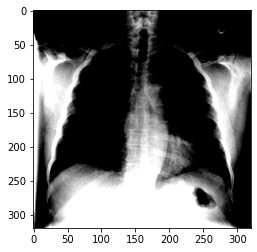

In [ ]:
x, y = train_generator.__getitem__(0)
plt.imshow(x[0])

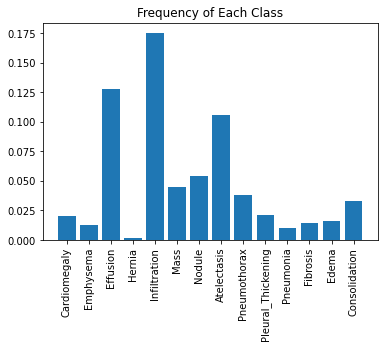

In [ ]:
# Addressing Class Imbalance
plt.xticks(rotation = 90)
plt.bar(x = labels, height = np.mean(train_generator.labels, axis = 0))
plt.title('Frequency of Each Class')
plt.show()

In [ ]:
#computing class frequencies
def compute_class_freqs(labels):
    N = labels.shape
    
    positive_frequencies = np.sum(labels == 1, axis = 0) / labels.shape[0]
    negative_frequencies = np.sum(labels == 0, axis = 0) / labels.shape[0]
    
    return positive_frequencies, negative_frequencies
    

In [ ]:
# Test
labels_matrix = np.array(
    [[1, 0, 0],
     [0, 1, 1],
     [1, 0, 1],
     [1, 1, 1],
     [1, 0, 1]]
)
print("labels:")
print(labels_matrix)

test_pos_freqs, test_neg_freqs = compute_class_freqs(labels_matrix)

print(f"pos freqs: {test_pos_freqs}")

print(f"neg freqs: {test_neg_freqs}")

labels:
[[1 0 0]
 [0 1 1]
 [1 0 1]
 [1 1 1]
 [1 0 1]]
pos freqs: [0.8 0.4 0.8]
neg freqs: [0.2 0.6 0.2]


In [ ]:
freq_pos, freq_neg = compute_class_freqs(train_generator.labels)
freq_pos

array([0.02 , 0.013, 0.128, 0.002, 0.175, 0.045, 0.054, 0.106, 0.038,
       0.021, 0.01 , 0.014, 0.016, 0.033])

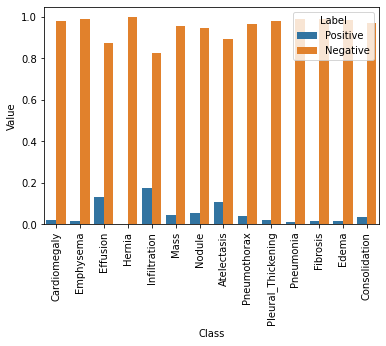

In [ ]:
data = pd.DataFrame({"Class": labels, "Label": "Positive", "Value": freq_pos})
data = data.append([{"Class": labels[l], "Label": "Negative", "Value": v} for l,v in enumerate(freq_neg)], ignore_index=True)
plt.xticks(rotation=90)
f = sns.barplot(x="Class", y="Value", hue="Label" ,data=data)

In [ ]:
pos_weights = freq_neg
neg_weights = freq_pos
pos_contribution = freq_pos *pos_weights
neg_contribution = freq_neg * neg_weights



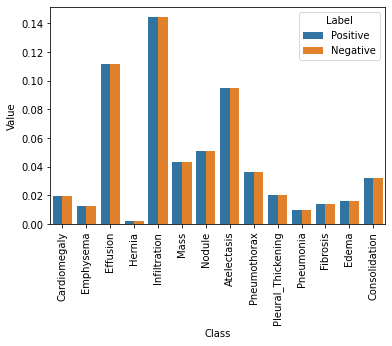

In [ ]:
data = pd.DataFrame({"Class": labels, "Label": "Positive", "Value": pos_contribution})
data = data.append([{"Class": labels[l], "Label": "Negative", "Value": v} 
                        for l,v in enumerate(neg_contribution)], ignore_index=True)
plt.xticks(rotation=90)
sns.barplot(x="Class", y="Value", hue="Label" ,data=data);

In [ ]:
#weighted loss

def get_weighted_loss(pos_weights, neg_weights, epsilon = 1e-7):
    
    def weighted_loss(y_true, y_pred):
        
        loss = 0.0
        
        for i in range(len(pos_weights)):
            loss += -1 * K.mean(pos_weights[i]* y_true[:,i] * K.log(y_pred[:,i] + epsilon))
            loss += -1 * K.mean(neg_weights[i]*(1 - y_true[:,i]) * K.log(1 - y_pred[:,i] + epsilon))
        return loss
        
        weighted_loss= loss
        
    return weighted_loss

In [ ]:
#test# Test


sess = K.get_session()
with sess.as_default() as sess:
    print("Test example:\n")
    y_true = K.constant(np.array(
        [[1, 1, 1],
         [1, 1, 0],
         [0, 1, 0],
         [1, 0, 1]]
    ))
    print("y_true:\n")
    print(y_true.eval())

    w_p = np.array([0.25, 0.25, 0.5])
    w_n = np.array([0.75, 0.75, 0.5])
    print("\nw_p:\n")
    print(w_p)

    print("\nw_n:\n")
    print(w_n)

    y_pred_1 = K.constant(0.7*np.ones(y_true.shape))
    print("\ny_pred_1:\n")
    print(y_pred_1.eval())

    y_pred_2 = K.constant(0.3*np.ones(y_true.shape))
    print("\ny_pred_2:\n")
    print(y_pred_2.eval())

    # test with a large epsilon in order to catch errors
    L = get_weighted_loss(w_p, w_n, epsilon=1)

    print("\nIf we weighted them correctly, we expect the two losses to be the same.")
    L1 = L(y_true, y_pred_1).eval()
    L2 = L(y_true, y_pred_2).eval()
    print(f"\nL(y_pred_1)= {L1:.4f}, L(y_pred_2)= {L2:.4f}")
    print(f"Difference is L1 - L2 = {L1 - L2:.4f}")

Test example:

y_true:

[[1. 1. 1.]
 [1. 1. 0.]
 [0. 1. 0.]
 [1. 0. 1.]]

w_p:

[0.25 0.25 0.5 ]

w_n:

[0.75 0.75 0.5 ]

y_pred_1:

[[0.7 0.7 0.7]
 [0.7 0.7 0.7]
 [0.7 0.7 0.7]
 [0.7 0.7 0.7]]

y_pred_2:

[[0.3 0.3 0.3]
 [0.3 0.3 0.3]
 [0.3 0.3 0.3]
 [0.3 0.3 0.3]]

If we weighted them correctly, we expect the two losses to be the same.

L(y_pred_1)= -0.4956, L(y_pred_2)= -0.4956
Difference is L1 - L2 = -0.0000


In [ ]:
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
base_model = DenseNet121(weights='/content/drive/MyDrive/md/densenet.hdf5',include_top=False)

x = base_model.output

x = GlobalAveragePooling2D()(x)
x = Dropout((0.3))(x)
predictions = Dense(len(labels), activation = 'sigmoid')(x)

model = Model(inputs = base_model.input, outputs = predictions)
model.summary()
model.compile(optimizer = 'adam', loss = get_weighted_loss(pos_weights, neg_weights))
#model.compile(optimizer = 'adam', loss = 'categorical_crossentropy')

In [ ]:
history = model.fit_generator(train_generator, 
                              validation_data=valid_generator,
                              steps_per_epoch=125, 
                              validation_steps=40, 
                              epochs = 15)

plt.plot(history.history['loss'])
plt.ylabel("loss")
plt.xlabel("epoch")
plt.title("Training Loss Curve")
plt.show()

Epoch 1/15
125/125 [==============================] - 109s 874ms/step - loss: 0.9592 - val_loss: 23.6160
Epoch 2/15
125/125 [==============================] - 75s 597ms/step - loss: 0.8955 - val_loss: 24.5560
Epoch 3/15
125/125 [==============================] - 74s 593ms/step - loss: 0.8836 - val_loss: 4.2167
Epoch 4/15
125/125 [==============================] - 74s 596ms/step - loss: 0.8448 - val_loss: 6.3202
Epoch 5/15
125/125 [==============================] - 76s 605ms/step - loss: 0.8518 - val_loss: 29.8274
Epoch 6/15
 43/125 [=========>....................] - ETA: 45s - loss: 0.8995

KeyboardInterrupt: ignored

In [ ]:
model.load_weights("/content/drive/MyDrive/md/pretrained_model.h5")

predicted_vals = model.predict_generator(test_generator, steps = len(test_generator))

In [ ]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
zero_padding2d_11 (ZeroPadding2 (None, None, None, 3 0           input_6[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, None, None, 6 9408        zero_padding2d_11[0][0]          
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, None, None, 6 256         conv1/conv[0][0]                 
____________________________________________________________________________________________

In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/md')


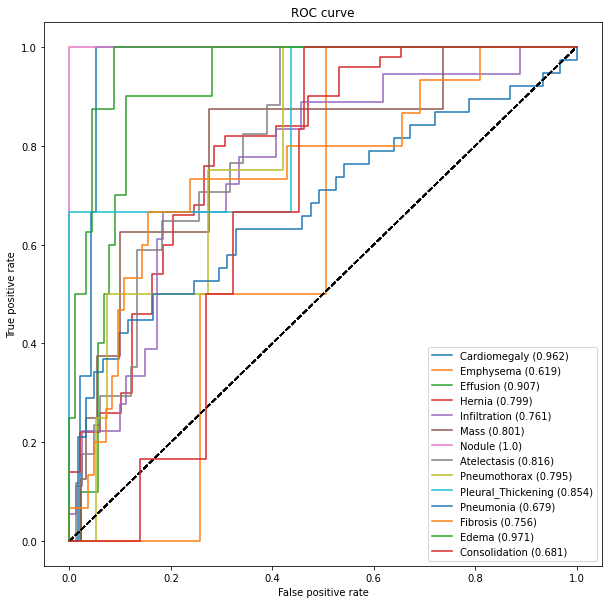

In [ ]:
import util1
model.load_weights("/content/drive/MyDrive/md/pretrained_model.h5")

predicted_vals = model.predict_generator(test_generator, steps = len(test_generator))
auc_rocs = util1.get_roc_curve(labels, predicted_vals, test_generator)

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/md/train-small.csv")
IMAGE_DIR = "/content/drive/MyDrive/md/images-small/"

# only show the labels with top 4 AUC
labels_to_show = np.take(labels, np.argsort(auc_rocs)[::-1])[:4]

Loading original image
Generating gradcam for class Cardiomegaly
Generating gradcam for class Effusion
Generating gradcam for class Nodule
Generating gradcam for class Edema


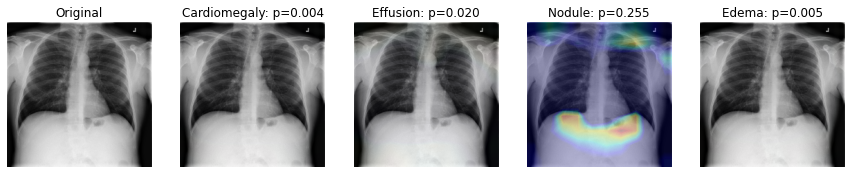

In [ ]:
util1.compute_gradcam(model, '00008270_015.png', IMAGE_DIR, df, labels, labels_to_show)

Loading original image
Generating gradcam for class Cardiomegaly
Generating gradcam for class Effusion
Generating gradcam for class Nodule
Generating gradcam for class Edema


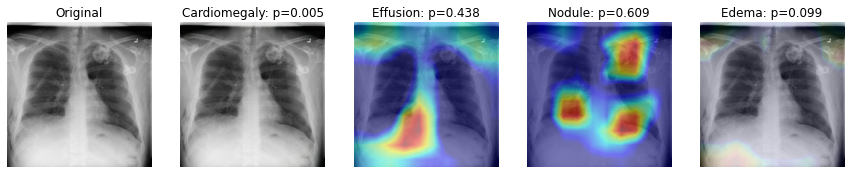

In [ ]:
util1.compute_gradcam(model, '00011355_002.png', IMAGE_DIR, df, labels, labels_to_show)